# TD3 - ConvNets

Yiming CHEN, X2023

In [1]:
import os
import torch
from torch import nn
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

def set_manual_seed(seed=114514):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [ ]:
# patch conda duplicate libiomp5md.dll
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
set_manual_seed()

## Pooling

In a neural network, pooling is used to reduce the dimensionality of an image. Pooling layers reduce height and width of the input images. Pooling analyzes filter-sized regions and keeps only one statistic about this region (e.g. minimal/maximal/average value).


<center>

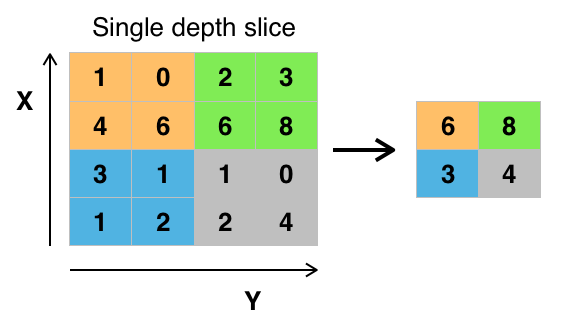

*Max pooling with a size 2x2 filter and stride 2.*

</center>

There exists several pooling methods and it can be useful to choose the best method for the considered problem.

> **Question 1** Get 16 images of the MNIST dataset, this dataset can be manipulated in the same way as the FashionMNIST dataset of previous TDs. It is not necessary to normalize it.

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

training_data = datasets.MNIST('../data', download=True, train=True, transform=transform)

> **Question 2** Apply max pooling, average pooling and min pooling on these images. Use the `torch.nn.MaxPool2d()` and `torch.nn.AvgPool2d()` with a 3x3 filter. Note the first dimension of the inputs and outputs of the layers is the batch size. You can use the view method to change the apparent dimension of a tensor. Since minpooling is not directly implemented, you must find a way to obtain it from one the implemented pooling layers.

In [4]:
imgs = torch.stack([training_data[i][0] for i in range(16)])

# Max pooling
max_pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=0)
imgs_max_pooled = max_pool(imgs)

# Avg pooling
avg_pool = nn.AvgPool2d(kernel_size=3, stride=1, padding=0)
imgs_avg_pooled = avg_pool(imgs)

# Min pooling
class MinPool2d(nn.Module):
    def __init__(self, kernel_size: int, stride: int, padding: int):
        super().__init__()
        self.f = nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=padding)
    def forward(self, input: torch.Tensor):
        return -self.f(-input)

setattr(nn, 'MinPool2d', MinPool2d)

min_pool = nn.MinPool2d(kernel_size=3, stride=1, padding=0)
imgs_min_pooled = min_pool(imgs)
imgs_min_pooled.shape

torch.Size([16, 1, 26, 26])

> **Question 3** Using `matplotlib` display the 16 original images, the images after maxpoooling, after average pooling and after minpooling. In order to display several images at the same time you can use `torchvision.utils.make_grid` to concatenate a batch of images and display them as a grid.

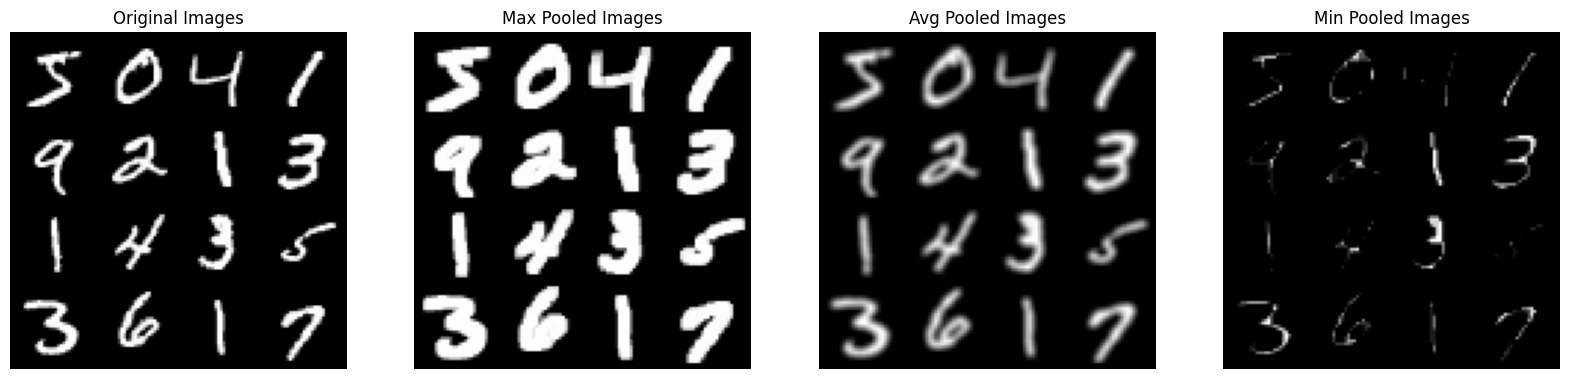

In [5]:
grids = list(map(lambda x: utils.make_grid(x, nrow=4, padding=2),
                 [imgs, imgs_max_pooled, imgs_avg_pooled, imgs_min_pooled]))

titles = ['Original Images', 'Max Pooled Images', 'Avg Pooled Images', 'Min Pooled Images']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for idx, grid in enumerate(grids):
    axes[idx].imshow(grid.permute(1, 2, 0))
    axes[idx].set_title(titles[idx])
    axes[idx].axis('off')

## First CNN Architectures

### Trainers and Acc Test utilities

In [6]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm

def calc_acc(model, test_data):
    correct = 0
    total = 0
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).to(torch.int32)
            outputs = model(images)
            pred = torch.argmax(outputs, dim=1)
            total += labels.shape[0]
            correct += (pred == labels).sum().item()
    print(f"Acc: {correct} out of {total}, {correct/total}")
    return correct/total

class AdamTrainer:
    def __init__(self, model, dataset, loss_fn, batch_size=128, lr=1e-3, test_dataset = None):
        self.model = model
        self.dataset = dataset
        self.test_dataset = test_dataset
        
        self.loss_fn = loss_fn
        
        self.batch_size = batch_size
        self.lr = lr
        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        num_workers = min(4, os.cpu_count())
        
        self.dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=num_workers)
        self.optimizer = Adam(model.parameters(), lr=lr)
        self.current_epoch = 1
    
    def run(self, max_epoch = 10):
        device = self.device
        model = self.model
        model.to(device)
        while self.current_epoch <= max_epoch:
            model.train()
            pbar = tqdm(self.dataloader, desc=f"Epoch {self.current_epoch}/{max_epoch}", ncols=100)
            self.current_epoch += 1
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = self.loss_fn(outputs, labels)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                pbar.set_postfix(loss=loss.item())
            if self.test_dataset:
                calc_acc(model, self.test_dataset)

### Our First CNN

<center>
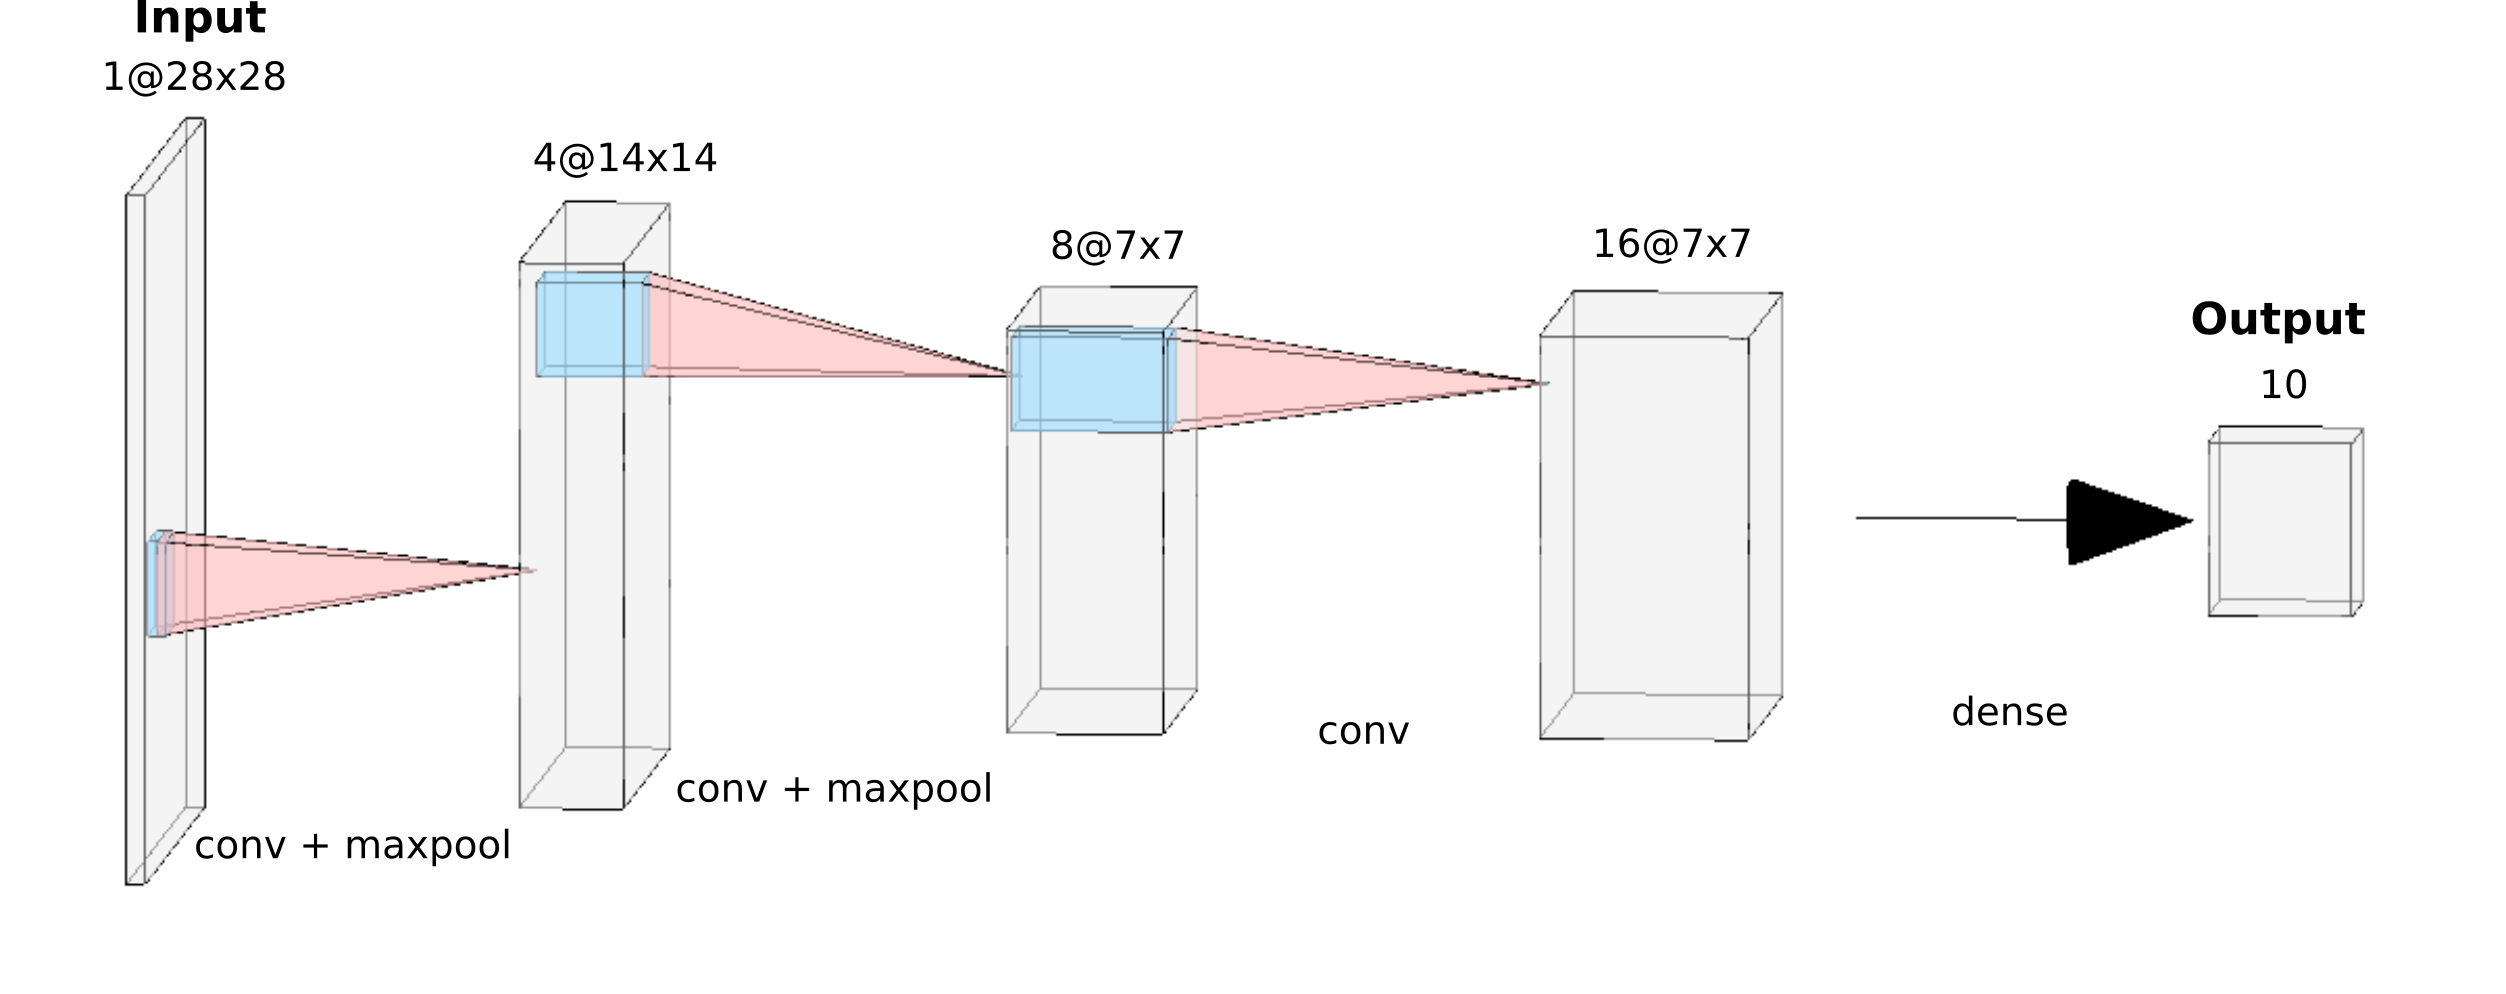
</center>

> **Question 4** Implement and train this network on the FashionMNIST dataset,
using a kernel of size 5x5. The input images must be normalized. You will train
with a 1e-3 learning rate, 5 epochs and the `nn.CrossEntropyLoss()` cost
function. Modify the padding and the stride in order to obtain exactly the
output image's sizes on the diagram. Note that to apply a dense (linear) layer
on the output of a convolutional layer, one must change the dimension of the
data, you can use `.view()` for this.

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, depths=[4, 8, 16], kernel_size=5):
        super().__init__()
        padding = (kernel_size - 1)//2
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=depths[0], kernel_size=kernel_size, stride=1, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=depths[0], out_channels=depths[1], kernel_size=5, stride=1, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=depths[1], out_channels=depths[2], kernel_size=5, stride=1, padding=padding),
            nn.ReLU(),
            
            nn.Flatten(),
            nn.LazyLinear(10)
        )
    def forward(self, input: torch.Tensor):
        return self.net(input)

In [8]:
training_data = datasets.FashionMNIST('../data', download=True, train=True, transform=transform)
test_data = datasets.FashionMNIST('../data', download=True, train=False, transform=transform)

set_manual_seed()
cnn = SimpleCNN()
calc_acc(cnn, test_data)
trainer = AdamTrainer(cnn, training_data, nn.CrossEntropyLoss(), lr=1e-3, batch_size=512, test_dataset = test_data)
trainer.run(max_epoch=5)

Acc: 1003 out of 10000, 0.1003


Epoch 1/5: 100%|██████████████████████████████████████| 118/118 [00:05<00:00, 19.87it/s, loss=0.947]


Acc: 7583 out of 10000, 0.7583


Epoch 2/5: 100%|██████████████████████████████████████| 118/118 [00:05<00:00, 20.42it/s, loss=0.419]


Acc: 7851 out of 10000, 0.7851


Epoch 3/5: 100%|██████████████████████████████████████| 118/118 [00:06<00:00, 19.55it/s, loss=0.426]


Acc: 8131 out of 10000, 0.8131


Epoch 4/5: 100%|██████████████████████████████████████| 118/118 [00:05<00:00, 20.12it/s, loss=0.397]


Acc: 8224 out of 10000, 0.8224


Epoch 5/5: 100%|██████████████████████████████████████| 118/118 [00:05<00:00, 20.88it/s, loss=0.412]


Acc: 8320 out of 10000, 0.832


#### Influence of the size of the filters

The number of parameters has an influence on the ability of the network to learn.

> **Question 5** Implement and train the same network using convolution filters of half the depth : depths 2, 4, and 8 instead of 4, 8 and 16. What happens ?

The accuracy of the network is lower when the depth of the filters is reduced. This is because the network has less capacity to learn.

In [9]:
set_manual_seed()
cnn2 = SimpleCNN(depths=[2,4,8])
calc_acc(cnn2, test_data)
cnn2_trainer = AdamTrainer(cnn2, training_data, nn.CrossEntropyLoss(), lr=1e-3, batch_size=512, test_dataset = test_data)
cnn2_trainer.run(max_epoch=5)

Acc: 350 out of 10000, 0.035


Epoch 1/5: 100%|██████████████████████████████████████| 118/118 [00:05<00:00, 20.58it/s, loss=0.776]


Acc: 7337 out of 10000, 0.7337


Epoch 2/5: 100%|███████████████████████████████████████| 118/118 [00:05<00:00, 20.01it/s, loss=0.61]


Acc: 7698 out of 10000, 0.7698


Epoch 3/5: 100%|██████████████████████████████████████| 118/118 [00:05<00:00, 19.85it/s, loss=0.434]


Acc: 7910 out of 10000, 0.791


Epoch 4/5: 100%|██████████████████████████████████████| 118/118 [00:06<00:00, 18.88it/s, loss=0.568]


Acc: 7951 out of 10000, 0.7951


Epoch 5/5: 100%|██████████████████████████████████████| 118/118 [00:06<00:00, 18.35it/s, loss=0.372]


Acc: 8100 out of 10000, 0.81


> **Question 6** Implement and train the same network using filters of smaller size : 3x3 instead of 5x5. What happens ?

Similarly, the accuracy of the network is lower when the size of the filters is reduced. However, they all reached at least 80% accuracy on the test set.

In [10]:
set_manual_seed()
cnn3 = SimpleCNN(depths=[2,4,8])
calc_acc(cnn3, test_data)
cnn3_trainer = AdamTrainer(cnn3, training_data, nn.CrossEntropyLoss(), lr=1e-3, batch_size=512, test_dataset = test_data)
cnn3_trainer.run(max_epoch=5)

Acc: 350 out of 10000, 0.035


Epoch 1/5: 100%|██████████████████████████████████████| 118/118 [00:06<00:00, 17.05it/s, loss=0.776]


Acc: 7339 out of 10000, 0.7339


Epoch 2/5: 100%|███████████████████████████████████████| 118/118 [00:06<00:00, 19.17it/s, loss=0.61]


Acc: 7698 out of 10000, 0.7698


Epoch 3/5: 100%|██████████████████████████████████████| 118/118 [00:06<00:00, 19.28it/s, loss=0.434]


Acc: 7910 out of 10000, 0.791


Epoch 4/5: 100%|██████████████████████████████████████| 118/118 [00:06<00:00, 18.10it/s, loss=0.568]


Acc: 7951 out of 10000, 0.7951


Epoch 5/5: 100%|██████████████████████████████████████| 118/118 [00:06<00:00, 18.60it/s, loss=0.372]


Acc: 8093 out of 10000, 0.8093


#### Influence of the depth of the network

> **Question 7** Compute the number of parameters of the first network of the exercise and the number of parameters of the network below.

In [11]:
class ConvDense(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1, padding=2),
            nn.Flatten(),
            nn.LazyLinear(10)
        )
    def forward(self, input: torch.Tensor):
        return self.net(input)
    
conv_dense = ConvDense()
dummy_input = torch.randn((25,1,28,28))
print(conv_dense)
print(conv_dense(dummy_input).shape)

ConvDense(
  (net): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): LazyLinear(in_features=0, out_features=10, bias=True)
  )
)
torch.Size([25, 10])


We can calculate by hand the number of parameters of the network.

`(1,28,28) -> Conv2d -> (4,28,28) -> Flatten -> (3136,) -> Linear -> (10,)`

`Conv2d: 4 * 5 * 5 + 4 = 104`

`Linear: 3136 * 10 + 10 = 31370`

So we have 31474 parameters in total. Same for the other networks.

We can also obtain the number of parameters using `model.parameters()`.

In [12]:
for model in [cnn, cnn2, cnn3, conv_dense]:
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params}")

Total parameters: 11978
Total parameters: 4994
Total parameters: 4994
Total parameters: 31474


> **Question 8** Implement and train this network.

In [13]:
set_manual_seed()
conv_dense = ConvDense()
calc_acc(conv_dense, test_data)
conv_dense_trainer = AdamTrainer(conv_dense, training_data, nn.CrossEntropyLoss(), lr=1e-3, batch_size=512, test_dataset = test_data)
conv_dense_trainer.run(max_epoch=5)

Acc: 416 out of 10000, 0.0416


Epoch 1/5: 100%|██████████████████████████████████████| 118/118 [00:05<00:00, 20.15it/s, loss=0.481]


Acc: 8061 out of 10000, 0.8061


Epoch 2/5: 100%|██████████████████████████████████████| 118/118 [00:05<00:00, 20.09it/s, loss=0.554]


Acc: 8255 out of 10000, 0.8255


Epoch 3/5: 100%|███████████████████████████████████████| 118/118 [00:05<00:00, 20.28it/s, loss=0.38]


Acc: 8287 out of 10000, 0.8287


Epoch 4/5: 100%|███████████████████████████████████████| 118/118 [00:06<00:00, 19.11it/s, loss=0.28]


Acc: 8353 out of 10000, 0.8353


Epoch 5/5: 100%|██████████████████████████████████████| 118/118 [00:05<00:00, 19.81it/s, loss=0.384]


Acc: 8322 out of 10000, 0.8322


### LeNet

<center>
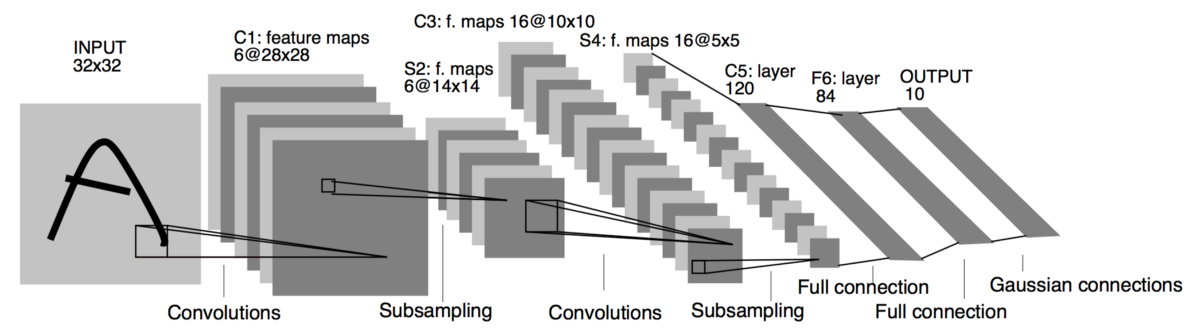
</center>

> **Question 9** Implement LeNet and train it on the FashionMNIST dataset.

Note that in the original paper of LeNet, the activation function is not ReLU. 

In [14]:
import torch
import torch.nn as nn

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()        
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2), 
            
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.ReLU(),
            
            nn.LazyLinear(84),
            nn.ReLU(),
            
            nn.LazyLinear(10)
        )

    def forward(self, input: torch.Tensor):
        return self.net(input)

In [15]:
set_manual_seed()
lenet = LeNet()
calc_acc(lenet, test_data)
lenet_trainer = AdamTrainer(lenet, training_data, nn.CrossEntropyLoss(), lr=1e-3, batch_size=512, test_dataset = test_data)
lenet_trainer.run(max_epoch=5)

Acc: 938 out of 10000, 0.0938


Epoch 1/5: 100%|██████████████████████████████████████| 118/118 [00:06<00:00, 19.56it/s, loss=0.597]


Acc: 7018 out of 10000, 0.7018


Epoch 2/5: 100%|██████████████████████████████████████| 118/118 [00:05<00:00, 19.85it/s, loss=0.481]


Acc: 7550 out of 10000, 0.755


Epoch 3/5: 100%|██████████████████████████████████████| 118/118 [00:05<00:00, 19.70it/s, loss=0.388]


Acc: 7902 out of 10000, 0.7902


Epoch 4/5: 100%|██████████████████████████████████████| 118/118 [00:06<00:00, 19.38it/s, loss=0.352]


Acc: 8027 out of 10000, 0.8027


Epoch 5/5: 100%|████████████████████████████████████████| 118/118 [00:05<00:00, 19.72it/s, loss=0.5]


Acc: 7916 out of 10000, 0.7916


## Parameter Sharing

The parameters of a convolutional network consist of a set of filters. Each filter is limited in space, but spans the whole depth of the input volume. Intuitively, the network learns different type of filters, which activate when they see some kind of property on one of the first layers, such as a border or a colored spot. The deeper the layer, the more complex the patterns represented are.

> **Question 10** Display the weights of the first layer using the following code. What do you see ?

The first layer of a convolutional network is usually the one that learns simple patterns such as edges or colored spots.

c:\Users\ming\miniconda3\envs\mvd-3d\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ming\miniconda3\envs\mvd-3d\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


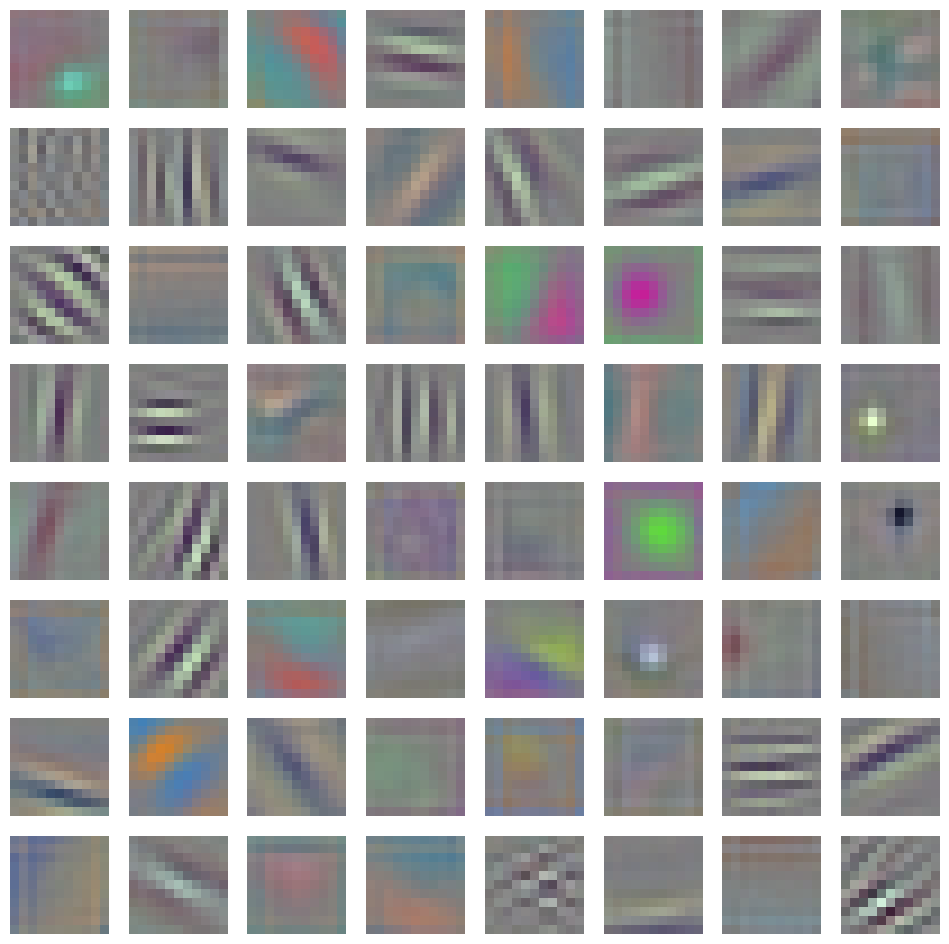

In [16]:
import torchvision.models as models

os.environ['TORCH_HOME'] = '../data'
# load pretrained model
alexnet = models.alexnet(pretrained=True)
# access weights from first layer
filter = alexnet.features[0].weight.data
# normalize to [0, 1]
filter = (1/(2*filter.max()))*filter + 0.5
# access weights from first layer
filter = alexnet.features[0].weight.data
# normalize to [0, 1]
filter = (1/(2*filter.max()))*filter + 0.5

# filter.shape == [64, 3, 11, 11]
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(filter[i].permute(1, 2, 0))
    ax.axis('off')
plt.show()

## Your Model of TD3 - Submission

Train the model for more epochs.

It would be possible using other regularization techniques such as weight decay,
dropout or batch normalization. Since our model has already a good performance,
we will not go further.

In [17]:
calc_acc(lenet, test_data)
lenet_trainer.run(max_epoch=25)

Acc: 7916 out of 10000, 0.7916


Epoch 6/25: 100%|█████████████████████████████████████| 118/118 [00:06<00:00, 19.13it/s, loss=0.476]


Acc: 8294 out of 10000, 0.8294


Epoch 7/25: 100%|█████████████████████████████████████| 118/118 [00:05<00:00, 20.43it/s, loss=0.394]


Acc: 8349 out of 10000, 0.8349


Epoch 8/25: 100%|█████████████████████████████████████| 118/118 [00:06<00:00, 19.31it/s, loss=0.427]


Acc: 8418 out of 10000, 0.8418


Epoch 9/25: 100%|██████████████████████████████████████| 118/118 [00:06<00:00, 19.25it/s, loss=0.67]


Acc: 8394 out of 10000, 0.8394


Epoch 10/25: 100%|████████████████████████████████████| 118/118 [00:05<00:00, 20.46it/s, loss=0.344]


Acc: 8494 out of 10000, 0.8494


Epoch 11/25: 100%|████████████████████████████████████| 118/118 [00:05<00:00, 19.91it/s, loss=0.298]


Acc: 8473 out of 10000, 0.8473


Epoch 12/25: 100%|██████████████████████████████████████| 118/118 [00:06<00:00, 19.54it/s, loss=0.3]


Acc: 8587 out of 10000, 0.8587


Epoch 13/25: 100%|████████████████████████████████████| 118/118 [00:06<00:00, 18.83it/s, loss=0.292]


Acc: 8649 out of 10000, 0.8649


Epoch 14/25: 100%|█████████████████████████████████████| 118/118 [00:06<00:00, 19.23it/s, loss=0.29]


Acc: 8523 out of 10000, 0.8523


Epoch 15/25: 100%|████████████████████████████████████| 118/118 [00:06<00:00, 18.46it/s, loss=0.217]


Acc: 8642 out of 10000, 0.8642


Epoch 16/25: 100%|████████████████████████████████████| 118/118 [00:06<00:00, 19.24it/s, loss=0.429]


Acc: 8663 out of 10000, 0.8663


Epoch 17/25: 100%|████████████████████████████████████| 118/118 [00:06<00:00, 19.26it/s, loss=0.261]


Acc: 8645 out of 10000, 0.8645


Epoch 18/25: 100%|████████████████████████████████████| 118/118 [00:06<00:00, 18.13it/s, loss=0.425]


Acc: 8605 out of 10000, 0.8605


Epoch 19/25: 100%|████████████████████████████████████| 118/118 [00:06<00:00, 18.05it/s, loss=0.244]


Acc: 8766 out of 10000, 0.8766


Epoch 20/25: 100%|████████████████████████████████████| 118/118 [00:06<00:00, 17.87it/s, loss=0.304]


Acc: 8713 out of 10000, 0.8713


Epoch 21/25: 100%|████████████████████████████████████| 118/118 [00:05<00:00, 19.88it/s, loss=0.468]


Acc: 8791 out of 10000, 0.8791


Epoch 22/25: 100%|████████████████████████████████████| 118/118 [00:06<00:00, 19.42it/s, loss=0.261]


Acc: 8820 out of 10000, 0.882


Epoch 23/25: 100%|████████████████████████████████████| 118/118 [00:05<00:00, 19.99it/s, loss=0.409]


Acc: 8813 out of 10000, 0.8813


Epoch 24/25: 100%|████████████████████████████████████| 118/118 [00:05<00:00, 19.91it/s, loss=0.409]


Acc: 8761 out of 10000, 0.8761


Epoch 25/25: 100%|████████████████████████████████████| 118/118 [00:05<00:00, 19.69it/s, loss=0.246]


Acc: 8776 out of 10000, 0.8776


Save the model

In [ ]:
import cloudpickle as pickle
def torch_saver(net,filename):
  with open(filename, 'wb') as f:
    pickle.dump(net,f)
    
torch_saver(lenet, "./work_dir/le_net_local.pkl")